<a href="https://colab.research.google.com/github/baicheto/AML_Bitcoin/blob/Kri/AML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anti-Money Launderig - Elliptic dataset**
- The dataset is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.
- The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.



In [ ]:
!pip install --quiet --upgrade pip setuptools
!pip install --quiet torch_geometric gensim matplotlib seaborn networkx python-louvain scikit-learn scipy

In [2]:
# # for CUDA 11.6 + PyTorch 1.13.0
# !pip install --quiet torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install --quiet torch-sparse  -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install --quiet torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install --quiet torch-spline-conv -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip install --quiet pyg-lib

In [ ]:
# First, uninstall existing versions to avoid conflicts
!pip uninstall -y torch torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric

# Install PyTorch 2.0.0 with CUDA 11.7
!pip install --quiet torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

# Install PyTorch Geometric dependencies with prebuilt wheels
!pip install --quiet torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu117.html


**After running the cells above, manually Restart Runtime**

In [1]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/AML/elliptic_bitcoin_dataset'


Mounted at /content/drive


In [43]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import random, multiprocessing as mp, itertools, json, os
import gensim
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch_geometric
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score, average_precision_score


print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

Torch version: 2.0.0+cu117
Torch Geometric version: 2.6.1


### 1. Read the files

In [3]:
features = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
edges = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
classes = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

In [4]:
trans_features = ["trans_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + trans_features + agg_features

print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")


Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [5]:
features.head()

,txId,time_step,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [6]:
edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [7]:
classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


Map the illicit, licit, unknown transactions to 1, 2 and 0 respectively

In [8]:
# classes['class'] = classes['class'].replace({'unknown': 0, '1': 1, '2': 2})
classes['class'] = classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * classes['class'].value_counts(normalize=True), 2)
class_counts = classes['class'].value_counts()

In [9]:
classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,licit
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,illicit
203767,158654197,unknown


In [10]:
classes_df = classes[['txId', 'class']].copy()
classes_df['Percentage'] = classes_df['class'].map(percentage_distribution)
classes_df['Counts'] = classes_df['class'].map(class_counts)

In [11]:
classes_df

,txId,class,Percentage,Counts
0,230425980,unknown,77.15,157205
1,5530458,unknown,77.15,157205
2,232022460,unknown,77.15,157205
3,232438397,licit,20.62,42019
4,230460314,unknown,77.15,157205
...,...,...,...,...
203764,173077460,unknown,77.15,157205
203765,158577750,unknown,77.15,157205
203766,158375402,illicit,2.23,4545
203767,158654197,unknown,77.15,157205


**EDA**

Let's create a NetworkX graph G from the edge list, where:

Each node is a Bitcoin transaction (txId1, txId2).

Each edge represents a transaction flow between two transactions (a directed connection in practice)

In [12]:
# Let's create a graph
G = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

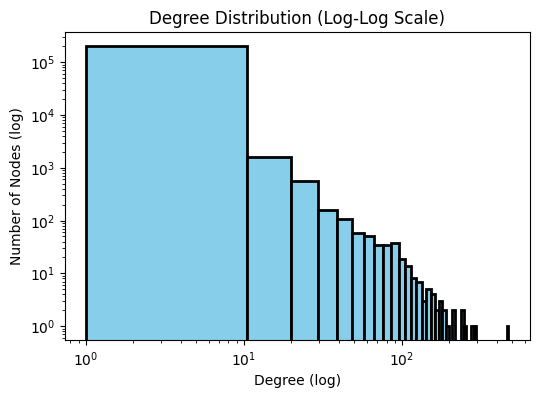

In [13]:
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

This graph shows that the network has a heavy-tailed degree distribution.

A few transactions interact with many others — potential hubs.

Most transactions interact with very few others.

The results are pretty common for financial-transaction graphs

In [14]:
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

Number of connected components: 49


In [15]:
# Giant component analysis (largest connected cluster)
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


**Node centrality measures**

### Degree centrality
- measures the number of direct connections a node has in a network. It is defined as the number of edges connected to a node.
A node with a high degree centrality is highly connected and may play a crucial role in the network by having direct interactions with many other nodes.

In [ ]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

# Subgraph of top nodes
top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)

# Get node colors based on centrality
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
cmap = plt.cm.cool

# Create scalar mappable for the colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


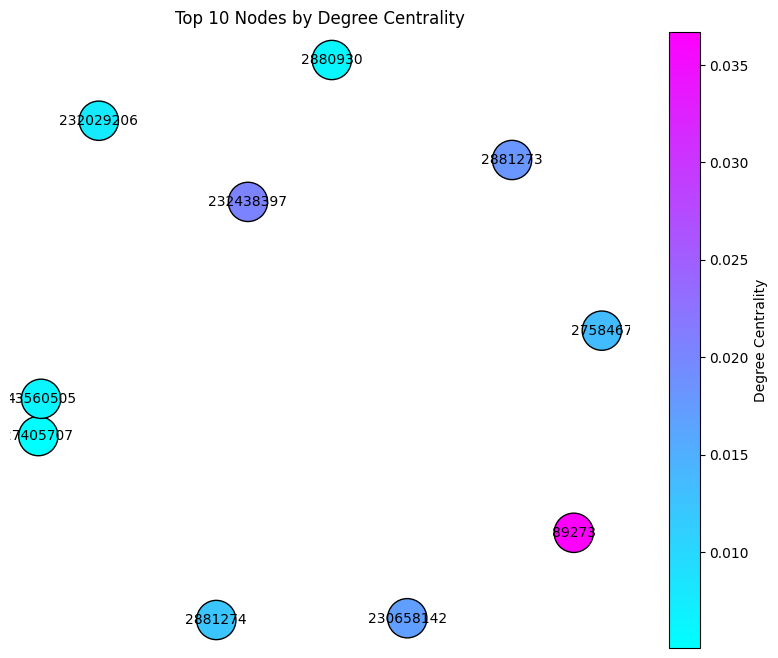

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color, cmap=cmap, node_size=800, edgecolors='black')
nx.draw_networkx_edges(subgraph, pos)
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.colorbar(sm, label='Degree Centrality', ax=plt.gca())
plt.title('Top 10 Nodes by Degree Centrality')
plt.axis('off')
plt.show()


### 2. Betweeness Centrality
- Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

- A node with high betweenness centrality has significant control over the flow of information or resources in the network because it connects different parts of the network. It often indicates a node that is critical for communication.

In [ ]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


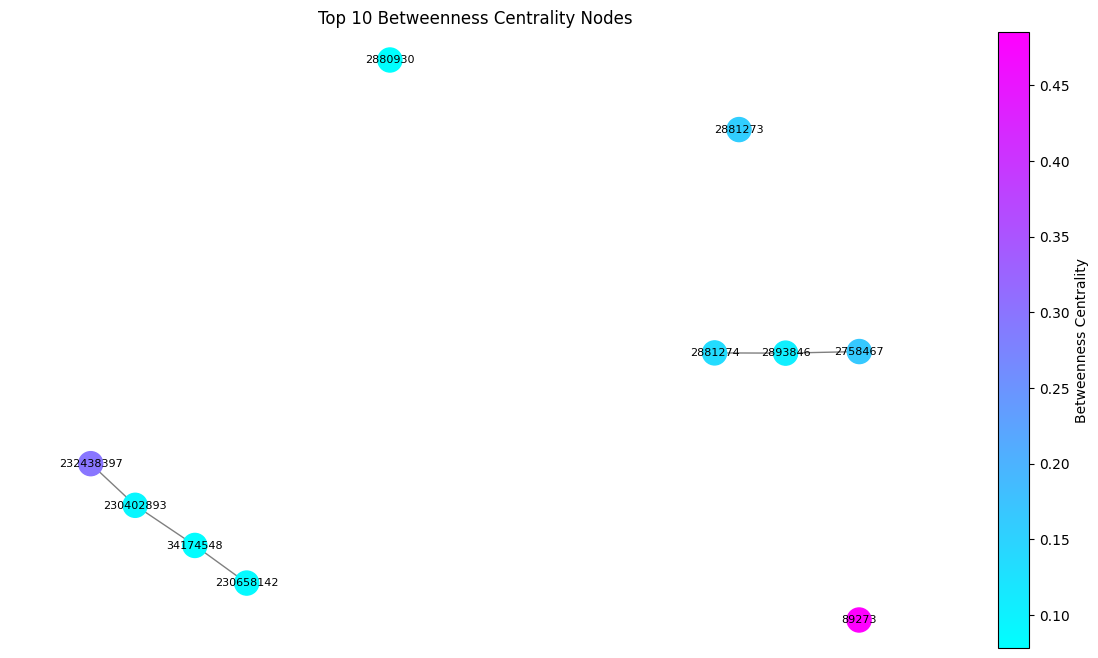

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(subgraph, pos,
                               node_color=node_color,
                               cmap=cmap,
                               node_size=300,
                               ax=ax)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Betweenness Centrality')

ax.set_title('Top 10 Betweenness Centrality Nodes')
ax.axis('off')
plt.show()

### 3. Closeness Centrality
- Closeness centrality measures how close a node is to all other nodes in the network. It is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network.
-  A node with high closeness centrality can quickly interact with all other nodes and can be an effective spreader of information or influence throughout the network.

In [ ]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool


Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


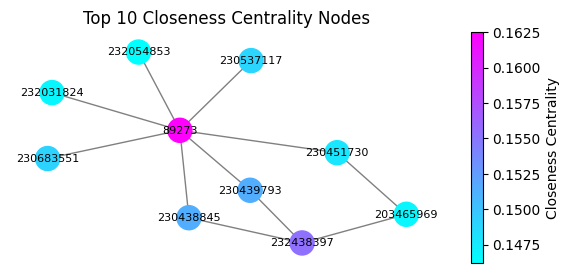

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(
    subgraph, pos,
    node_color=node_color,
    cmap=cmap,
    node_size=300,
    ax=ax
)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

# Create colorbar from scalar mappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Closeness Centrality')

ax.set_title('Top 10 Closeness Centrality Nodes')
ax.axis('off')
plt.show()

**Class-specific analysis**

In [ ]:
# Class-based subgraphs.
#illicit_nodes = classes_df[classes_df['class'] == 1]['txId']
#licit_nodes = classes_df[classes_df['class'] == 2]['txId']
illicit_nodes = classes_df[classes_df['class'] == 'illicit']['txId']
licit_nodes = classes_df[classes_df['class'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

Text(0.5, 1.0, 'Illicit Transactions Subgraph')

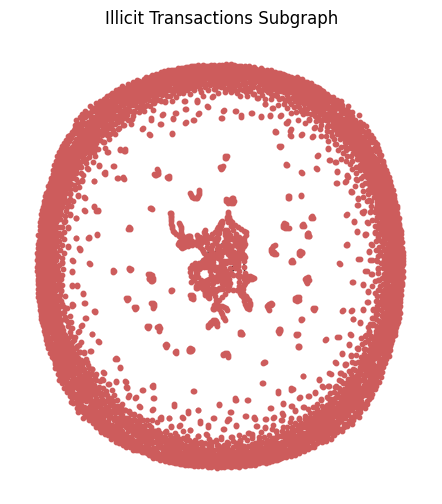

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')

In [ ]:
# plt.subplot(1, 2, 2)
# nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
# plt.title('Licit Transactions Subgraph')

# plt.show()

In [ ]:
# class_values = sorted(classes["class"].unique())

In [ ]:
# tx_idx = {name: idx for idx, name in enumerate(sorted(classes["txId"].unique()))}

In [ ]:
# classes["txId"] = classes["txId"].apply(lambda name: tx_idx[name])

## DeepWalk

In [16]:
G_base = G_giant

In [17]:
all_nodes = list(G_base.nodes())
tx_idx = {tx: i for i, tx in enumerate(sorted(all_nodes))}
idx2tx = {i: tx for tx, i in tx_idx.items()}

In [18]:
# Build Integer Graph
def nx_from_edgelist(df_edges, mapping):
    df_int = df_edges.replace({'txId1': mapping, 'txId2': mapping})
    return nx.from_pandas_edgelist(df_int, 'txId1', 'txId2')

In [19]:
base_edges = edges[edges['txId1'].isin(G_base.nodes())]
base_edges = base_edges[base_edges['txId2'].isin(G_base.nodes())]

G_int = nx_from_edgelist(base_edges, tx_idx)

In [20]:
def random_walk(graph, start, walk_length, rng=None):
    walk = [start]
    if rng is None:
        rng = random.Random()

    for _ in range(walk_length - 1):
        cur = walk[-1]
        neighbours = list(graph[cur])
        if neighbours:
            walk.append(rng.choice(neighbours))
        else:
            break
    return walk

In [21]:
def _walk_worker(args):
    graph, node_batch, walk_len, walks_per_node = args
    rng = random.Random()
    walks = []
    for n in node_batch:
        for _ in range(walks_per_node):
            walks.append(random_walk(graph, n, walk_len, rng))
    return walks

In [22]:
def build_corpus(graph, walk_length=40, walks_per_node=10, workers=None):
    if workers is None:
        workers = mp.cpu_count()

    nodes = list(graph.nodes())
    np.random.shuffle(nodes)

    batches = np.array_split(nodes, workers)

    with mp.Pool(workers) as pool:
        results = pool.map(
            _walk_worker,
            [(graph, batch, walk_length, walks_per_node) for batch in batches]
        )

    return [walk for sub in results for walk in sub]

In [23]:
def train_word2vec(sentences, dim=128, window=10, epochs=5, neg=5, workers=mp.cpu_count()):
    model = Word2Vec(
        sentences=sentences,
        vector_size=dim,
        window=window,
        min_count=0,
        sg=1,
        hs=0,
        negative=neg,
        workers=workers,
        epochs=epochs,
        seed=42
    )
    return model

In [24]:
def save_embeddings(w2v_model, path_pt='deepwalk.pt', path_txt='deepwalk.txt'):
    vectors = torch.tensor(w2v_model.wv.vectors)          # (N, dim)
    torch.save(vectors, path_pt)

    with open(path_txt, 'w') as f:
        dim = vectors.shape[1]
        f.write(f"{vectors.shape[0]} {dim}\n")
        for node, vec in w2v_model.wv.key_to_index.items():
            vec_str = " ".join(map(str, w2v_model.wv[node]))
            f.write(f"{node} {vec_str}\n")

In [25]:
def run_deepwalk(graph, params):
    corpus = build_corpus(graph,
                          walk_length=params['walk_length'],
                          walks_per_node=params['walks_per_node'])
    w2v     = train_word2vec(corpus,
                             dim=params['dim'],
                             window=params['window'],
                             epochs=params['epochs'],
                             neg=params['neg'])
    save_embeddings(w2v,
                    path_pt=params['out_pt'],
                    path_txt=params['out_txt'])
    return w2v

In [26]:
params = dict(walk_length=40, walks_per_node=10,
              dim=128, window=10, epochs=5, neg=5,
              out_pt='elliptic_deepwalk.pt', out_txt='elliptic_deepwalk.txt')
run_deepwalk(G_int, params)

In [27]:
if __name__ == "__main__":
    default_pars = dict(
        walk_length=40,
        walks_per_node=10,
        dim=128,
        window=10,
        epochs=5,
        neg=5,
        out_pt='deepwalk_embeddings.pt',
        out_txt='deepwalk_embeddings.txt'
    )
    w2v_model = run_deepwalk(G_int, default_pars)
    print("Done! Embeddings saved to", default_pars['out_pt'])

Done! Embeddings saved to deepwalk_embeddings.pt


In [28]:
z = torch.load('elliptic_deepwalk.pt')  # (N, 128)

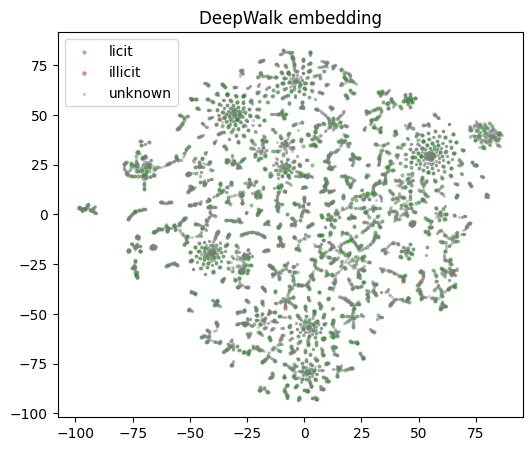

In [29]:
y = classes.set_index('txId')['class'].map({'illicit': 1, 'licit': 0, 'unknown': -1})

all_tx_ids_in_embedding_order = list(tx_idx.keys())
y = y[y.index.isin(all_tx_ids_in_embedding_order)]
y = y.reindex(all_tx_ids_in_embedding_order)
y = torch.tensor(y.values)

tsne = TSNE(n_components=2, perplexity=40, init='random', random_state=42)
xy = tsne.fit_transform(z.numpy())

plt.figure(figsize=(6, 5))
plt.scatter(xy[y == 0, 0], xy[y == 0, 1], s=4, c='forestgreen', label='licit', alpha=.4)
plt.scatter(xy[y == 1, 0], xy[y == 1, 1], s=5, c='indianred', label='illicit', alpha=.6)
plt.scatter(xy[y == -1, 0], xy[y == -1, 1], s=2, c='gray', label='unknown', alpha=0.3)

plt.legend()
plt.title("DeepWalk embedding")
plt.show()

## GRAPHSAGE

In [30]:
pyg_data = from_networkx(G_int)

In [31]:
feat_cols = trans_features + agg_features
ordered_txs = [idx2tx[i] for i in range(len(idx2tx))]
X = features.set_index('txId').loc[ordered_txs, feat_cols].values
pyg_data.x = torch.tensor(X, dtype=torch.float)

In [32]:
y_series = classes.set_index('txId')['class'].map({'licit':0, 'illicit':1, 'unknown':-1})
y = torch.tensor(y_series.loc[ordered_txs].values, dtype=torch.long)
pyg_data.y = y

In [33]:
num_nodes = y.size(0)
mask_known = (y >= 0)
known_indices = mask_known.nonzero(as_tuple=False).view(-1)
perm = known_indices[torch.randperm(known_indices.size(0))]
n_train = int(0.8 * perm.size(0))
n_val   = int(0.1 * perm.size(0))

train_idx = perm[:n_train]
val_idx   = perm[n_train:n_train+n_val]
test_idx  = perm[n_train+n_val:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[ val_idx]   = True
test_mask[test_idx]  = True

pyg_data.train_mask = train_mask
pyg_data.val_mask   = val_mask
pyg_data.test_mask  = test_mask

In [34]:
class GraphSAGENet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=2, dropout=0.5):
        super().__init__()
        convs = []
        convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            convs.append(SAGEConv(hidden_channels, hidden_channels))
        convs.append(SAGEConv(hidden_channels, out_channels))
        self.convs = nn.ModuleList(convs)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGENet(
    in_channels=pyg_data.x.size(1),
    hidden_channels=128,
    out_channels=2,
    num_layers=2,
    dropout=0.5
).to(device)
pyg_data = pyg_data.to(device)

In [35]:
train_loader = NeighborLoader(
    pyg_data,
    input_nodes= pyg_data.train_mask,
    num_neighbors=[15, 10],
    batch_size=64,
    shuffle=True
)
val_loader = NeighborLoader(
    pyg_data,
    input_nodes= pyg_data.val_mask,
    num_neighbors=[15, 10],
    batch_size=64
)
test_loader = NeighborLoader(
    pyg_data,
    input_nodes= pyg_data.test_mask,
    num_neighbors=[15, 10],
    batch_size=64
)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [37]:
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size
    return total_loss / pyg_data.train_mask.sum().item()

In [38]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    ys, preds = [], []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        y_true = batch.y[:batch.batch_size].cpu()
        y_pred = out[:batch.batch_size].argmax(dim=1).cpu()
        ys.append(y_true)
        preds.append(y_pred)
    y_true = torch.cat(ys)
    y_pred = torch.cat(preds)
    acc = (y_true == y_pred).float().mean().item()
    return acc, y_true, y_pred

In [39]:
epochs = 20
for epoch in range(1, epochs + 1):
    loss = train_epoch()
    val_acc, _, _ = evaluate(val_loader)
    print(f"Epoch {epoch:02d}  Train Loss: {loss:.4f}  Val Acc: {val_acc:.4f}")

Epoch 01  Train Loss: 0.1028  Val Acc: 0.9953
Epoch 02  Train Loss: 0.0467  Val Acc: 0.9953
Epoch 03  Train Loss: 0.0318  Val Acc: 0.9953
Epoch 04  Train Loss: 0.0317  Val Acc: 0.9953
Epoch 05  Train Loss: 0.0279  Val Acc: 0.9953
Epoch 06  Train Loss: 0.0221  Val Acc: 0.9953
Epoch 07  Train Loss: 0.0308  Val Acc: 0.9953
Epoch 08  Train Loss: 0.0230  Val Acc: 0.9953
Epoch 09  Train Loss: 0.0200  Val Acc: 0.9953
Epoch 10  Train Loss: 0.0236  Val Acc: 0.9953
Epoch 11  Train Loss: 0.0280  Val Acc: 0.9953
Epoch 12  Train Loss: 0.0226  Val Acc: 0.9953
Epoch 13  Train Loss: 0.0193  Val Acc: 0.9953
Epoch 14  Train Loss: 0.0184  Val Acc: 0.9953
Epoch 15  Train Loss: 0.0138  Val Acc: 0.9953
Epoch 16  Train Loss: 0.0363  Val Acc: 0.9953
Epoch 17  Train Loss: 0.0177  Val Acc: 0.9953
Epoch 18  Train Loss: 0.0252  Val Acc: 0.9907
Epoch 19  Train Loss: 0.0178  Val Acc: 0.9953
Epoch 20  Train Loss: 0.0201  Val Acc: 0.9953


In [40]:
test_acc, y_true_test, y_pred_test = evaluate(test_loader)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(classification_report(y_true_test, y_pred_test, target_names=['licit','illicit']))


Test Accuracy: 0.9954
              precision    recall  f1-score   support

       licit       1.00      1.00      1.00       215
     illicit       0.00      0.00      0.00         1

    accuracy                           1.00       216
   macro avg       0.50      0.50      0.50       216
weighted avg       0.99      1.00      0.99       216



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
@torch.no_grad()
def eval_auc():
    model.eval()
    out = model(pyg_data.x, pyg_data.edge_index).cpu()
    y_true = pyg_data.y.cpu()
    mask   = pyg_data.test_mask.cpu()
    probs  = F.softmax(out, dim=1)[:,1]  # P(illicit)
    return {
      "ROC AUC": roc_auc_score(y_true[mask], probs[mask]),
      "PR AUC":  average_precision_score(y_true[mask], probs[mask])
    }

metrics = eval_auc()
print(metrics)

{'ROC AUC': 0.32093023255813957, 'PR AUC': 0.006802721088435374}


## Deep Neural Decision Forest

In [50]:
model.eval()
with torch.no_grad():
    h = model.convs[0](pyg_data.x.to(device), pyg_data.edge_index.to(device))
    h = F.relu(h)
    h = F.dropout(h, p=model.dropout, training=False)
    embeddings = h.cpu()  # (N, 128)

y_all   = pyg_data.y.cpu()                 # (N,)
train_m = pyg_data.train_mask.cpu()
val_m   = pyg_data.val_mask.cpu()
test_m  = pyg_data.test_mask.cpu()

In [51]:
class DNDF(nn.Module):
    def __init__(self, input_dim, num_trees=5, depth=3, num_classes=2):
        super().__init__()
        self.num_trees = num_trees
        self.depth     = depth
        self.num_classes = num_classes

        self.I = 2**depth - 1   # internal nodes per tree
        self.L = 2**depth       # leaves per tree

        self.decision_w = nn.Parameter(torch.randn(num_trees*self.I, input_dim))
        self.decision_b = nn.Parameter(torch.zeros(num_trees*self.I))

        self.leaf_p     = nn.Parameter(torch.randn(num_trees, self.L, num_classes))

    def forward(self, x):
        """
        x: (N, input_dim)
        returns: log_probs (N, num_classes)
        """
        N = x.size(0)

        logits = F.linear(x, self.decision_w, self.decision_b)  # (N, T*I)
        probs  = torch.sigmoid(logits).view(N, self.num_trees, self.I)

        if not hasattr(self, 'leaf_decisions'):
            decisions = []
            for leaf_idx in range(self.L):
                path = []
                for node in range(self.I):
                    bit = ((leaf_idx >> (self.depth - 1 - int(torch.floor(torch.log2(torch.tensor(node+1)).float())))) & 1)
                    pass
            dec = torch.zeros(self.L, self.I)
            for l in range(self.L):
                idx = 0
                for d in range(self.depth):
                    half = 2**(self.depth-1-d)
                    if l < ( (l//half)*half + half//2 ):
                        dec[l, idx] = 1
                        idx = 2*idx + 1
                    else:
                        dec[l, idx] = 0
                        idx = 2*idx + 2
            self.leaf_decisions = dec  # (L, I)

        leaf_dec = self.leaf_decisions.to(probs.device)
        probs_exp = probs.unsqueeze(2).expand(-1, -1, self.L, -1)      # (N, T, L, I)
        leaf_dec_exp = leaf_dec.unsqueeze(0).unsqueeze(0)              # (1, 1, L, I)
        leaf_dec_exp = leaf_dec_exp.expand(N, self.num_trees, -1, -1)  # (N, T, L, I)

        p_left  = probs_exp
        p_right = 1 - probs_exp
        leaf_prob = torch.where(leaf_dec_exp==1, p_left, p_right).prod(dim=-1)

        leaf_scores = F.softmax(self.leaf_p, dim=-1)  # (T, L, C)

        tree_prob = torch.einsum('ntl,tlc->ntc', leaf_prob, leaf_scores)

        prob = tree_prob.mean(dim=1)      # (N, C)
        return torch.log(prob + 1e-6)

In [52]:
dndf = DNDF(input_dim=embeddings.size(1), num_trees=5, depth=3, num_classes=2).to(device)
opt2 = torch.optim.Adam(dndf.parameters(), lr=1e-3)
crit2 = nn.NLLLoss()

emb_dev = embeddings.to(device)
y_dev   = y_all.to(device)
t_m, v_m, te_m = train_m.to(device), val_m.to(device), test_m.to(device)

for epoch in range(1, 51):
    dndf.train()
    opt2.zero_grad()
    logp = dndf(emb_dev)          # (N, 2)
    loss = crit2(logp[t_m], y_dev[t_m])
    loss.backward()
    opt2.step()

    dndf.eval()
    with torch.no_grad():
        val_pred = logp[v_m].argmax(dim=1).cpu()
        val_true = y_dev[v_m].cpu()
        val_acc  = (val_pred == val_true).float().mean().item()
    print(f"DNDF Epoch {epoch:02d}  Loss: {loss:.4f}  Val Acc: {val_acc:.4f}")

DNDF Epoch 01  Loss: 9.8920  Val Acc: 0.7523
DNDF Epoch 02  Loss: 9.8370  Val Acc: 0.7523
DNDF Epoch 03  Loss: 9.7813  Val Acc: 0.7570
DNDF Epoch 04  Loss: 9.7249  Val Acc: 0.7570
DNDF Epoch 05  Loss: 9.6677  Val Acc: 0.7617
DNDF Epoch 06  Loss: 9.6097  Val Acc: 0.7523
DNDF Epoch 07  Loss: 9.5510  Val Acc: 0.7617
DNDF Epoch 08  Loss: 9.4918  Val Acc: 0.7710
DNDF Epoch 09  Loss: 9.4320  Val Acc: 0.7664
DNDF Epoch 10  Loss: 9.3716  Val Acc: 0.7710
DNDF Epoch 11  Loss: 9.3110  Val Acc: 0.7710
DNDF Epoch 12  Loss: 9.2500  Val Acc: 0.7757
DNDF Epoch 13  Loss: 9.1888  Val Acc: 0.7710
DNDF Epoch 14  Loss: 9.1273  Val Acc: 0.7757
DNDF Epoch 15  Loss: 9.0657  Val Acc: 0.7804
DNDF Epoch 16  Loss: 9.0039  Val Acc: 0.7804
DNDF Epoch 17  Loss: 8.9418  Val Acc: 0.7664
DNDF Epoch 18  Loss: 8.8796  Val Acc: 0.7664
DNDF Epoch 19  Loss: 8.8169  Val Acc: 0.7664
DNDF Epoch 20  Loss: 8.7539  Val Acc: 0.7617
DNDF Epoch 21  Loss: 8.6905  Val Acc: 0.7617
DNDF Epoch 22  Loss: 8.6264  Val Acc: 0.7570
DNDF Epoch

In [53]:
dndf.eval()
with torch.no_grad():
    logp = dndf(emb_dev)
    test_pred = logp[te_m].argmax(dim=1).cpu()
    test_true = y_dev[te_m].cpu()

print("DNDF Test Accuracy:", (test_pred==test_true).float().mean().item())
print(classification_report(test_true, test_pred, target_names=['licit','illicit']))


DNDF Test Accuracy: 0.7731481194496155
              precision    recall  f1-score   support

       licit       1.00      0.77      0.87       215
     illicit       0.02      1.00      0.04         1

    accuracy                           0.77       216
   macro avg       0.51      0.89      0.46       216
weighted avg       1.00      0.77      0.87       216



# TODO:
- explore the 89273 node (show whether it is illicit, licit, unknown)
- merge features with classes
- sort tx_idx for classes and edges
- ML classify only with the transaction features and only with the aggregated ones -> compare the results ? if enough time
- For Node2Vec use (trans, agg and all features -> compare results)
- Use GIN with (trans, agg and all features -> compare results)
- Apply Deep Neural Decision Forest (suggested by prof paper) ? if enough time